In [1]:
import tensorflow as tf
import numpy as np
import inceptionv3
from utils import *
from defense import *

W0219 15:47:23.997320 139863416362816 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
sess = tf.Session()

# Image and target class

Choose what you want here.

In [3]:
orig = load_image('cat.jpg')
TARGET = 924 # guacamole

# Classifier

In [4]:
x = tf.placeholder(tf.float32, (299, 299, 3))
x_expanded = tf.expand_dims(x, axis=0)
logits, preds = inceptionv3.model(sess, x_expanded)

W0219 15:47:33.449124 139863416362816 module_wrapper.py:139] From /home/zhouyi/obfuscated-gradients/inputtransformations/inceptionv3.py:30: The name tf.image.resize_bilinear is deprecated. Please use tf.compat.v1.image.resize_bilinear instead.

W0219 15:47:33.457444 139863416362816 deprecation.py:323] From /opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/contrib/layers/python/layers/layers.py:1057: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
W0219 15:47:35.817544 139863416362816 module_wrapper.py:139] From /home/zhouyi/obfuscated-gradients/inputtransformations/utils.py:14: The name tf.train.NewCheckpointReader is deprecated. Please use tf.compat.v1.train.NewCheckpointReader instead.

W0219 15:47:35.821237 139863416362816 module_wrapper.py:139] From /home/zhouyi/obfuscated-gradients/inputtransformations/utils.py:16: The name tf.global_v

In [5]:
probs = tf.nn.softmax(logits)
classify = make_classify(sess, x, probs)

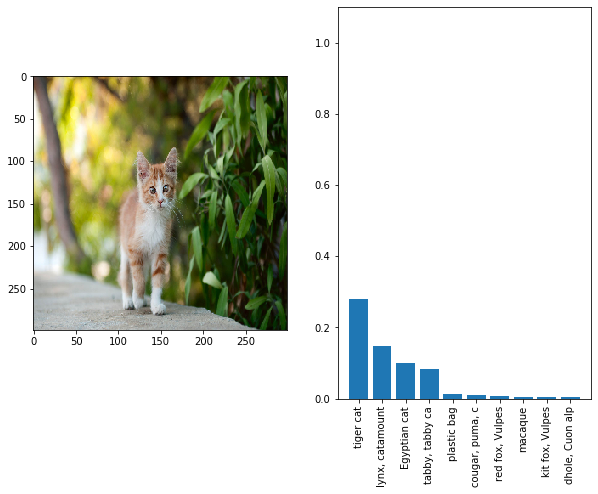

In [6]:
classify(orig, target_class=TARGET)

# Failed attack (attempting to transfer)

In [7]:
l2_x = tf.placeholder(tf.float32, (299, 299, 3))
l2_orig = tf.placeholder(tf.float32, (299, 299, 3))
normalized_l2_loss = tf.nn.l2_loss(l2_orig - l2_x) / tf.nn.l2_loss(l2_orig)

xent = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot(TARGET, 1000))
lam = tf.placeholder(tf.float32, ())
loss = xent + lam * normalized_l2_loss
grad, = tf.gradients(loss, x)

In [8]:
# PGD

LAM = 1.0
LR = 0.1

adv = np.copy(orig)
for i in range(10):
    g, l2, p = sess.run([grad, normalized_l2_loss, preds], {x: adv, lam: LAM, l2_x: adv, l2_orig: orig})
    print('step %d, l2=%f, pred=%d' % (i, l2, p))
    # step
    adv -= LR * g
    # project
    adv = np.clip(adv, 0, 1)

step 0, l2=0.000000, pred=282
step 1, l2=0.000056, pred=277
step 2, l2=0.000075, pred=231
step 3, l2=0.000095, pred=263
step 4, l2=0.000103, pred=274
step 5, l2=0.000116, pred=282
step 6, l2=0.000128, pred=231
step 7, l2=0.000147, pred=924
step 8, l2=0.000154, pred=924
step 9, l2=0.000157, pred=924


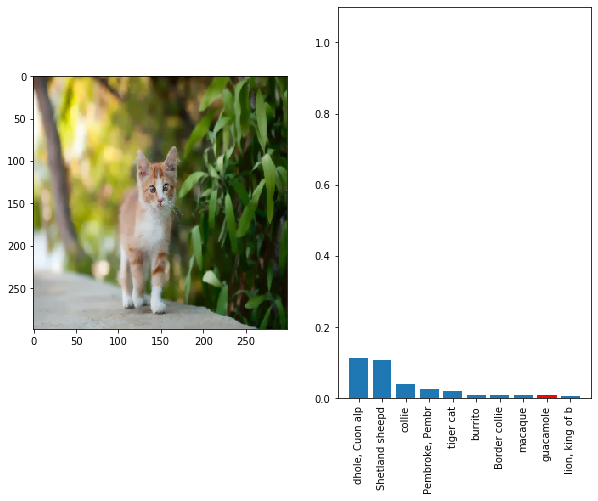

In [9]:
classify(defend_tv(adv), target_class=TARGET)

# Attack

Using BPDA.

In [10]:
# PGD

LAM = 1.0
LR = 0.1

adv = np.copy(orig)
for i in range(10):
    adv_def = defend_tv(adv)
    g, l2, p = sess.run([grad, normalized_l2_loss, preds], {x: adv_def, lam: LAM, l2_x: adv, l2_orig: orig})
    print('step %d, l2=%f, pred=%d' % (i, l2, p))
    # step
    adv -= LR * g
    # project
    adv = np.clip(adv, 0, 1)

step 0, l2=0.000000, pred=277
step 1, l2=0.000042, pred=282
step 2, l2=0.000180, pred=230
step 3, l2=0.000267, pred=157
step 4, l2=0.000290, pred=157
step 5, l2=0.000342, pred=924
step 6, l2=0.000383, pred=924
step 7, l2=0.000386, pred=924
step 8, l2=0.000389, pred=924
step 9, l2=0.000389, pred=924


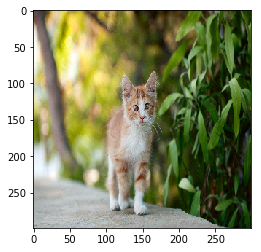

In [11]:
plt.imshow(adv)

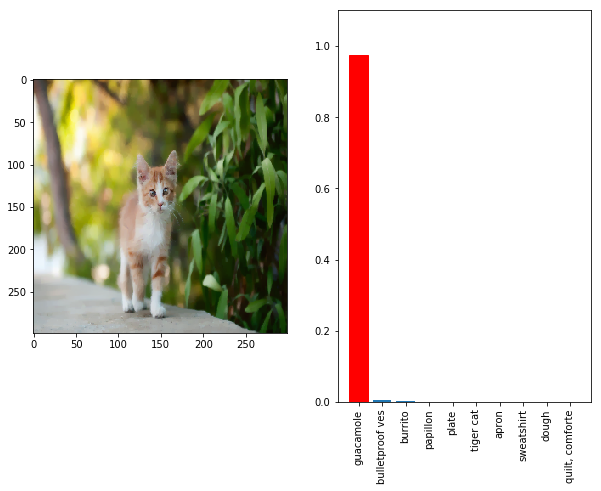

In [12]:
classify(defend_tv(adv), target_class=TARGET)